In [1]:
% load_ext autoreload
% autoreload 2

import numpy as np
from helpers import make_data, display_world, display_world_2

In [2]:
# world parameters
num_landmarks      = 1        # number of landmarks
N                  = 2       # time steps
world_size         = 20.0    # size of world (square)

# robot parameters
measurement_range  = 10.0     # range at which we can sense landmarks
motion_noise       = 0.0      # noise in robot motion
measurement_noise  = 0.0      # noise in the measurements
distance           = 5.0     # distance by which robot (intends to) move each iteratation 


In [3]:
my_data, mybot = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)
my_data

sense: x,y= 10.0 10.0 lm= 8 9 dx,dy= 2.0 1.0
make_data: robot.x,y=(10.0,10.0), dx,dy=(-4,3), Z=[[0, 2.0, 1.0]]
make_data: complete True
sense: x,y= 6.0 13.0 lm= 8 9 dx,dy= -2.0 4.0


[[[[0, 2.0, 1.0]], [-4, 3]], [[[0, -2.0, 4.0]], []]]

In [4]:
mybot.landmarks, mybot, len(my_data)

([[8, 9]], Robot: [x=6.00000 y=13.00000], 2)

display_world_2, lm= 8 9


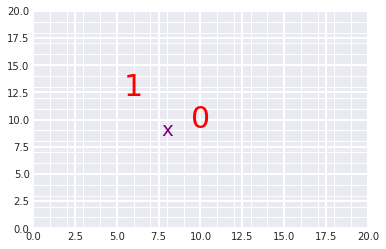

In [5]:
pos_list = [[world_size/2.0, world_size/2.0]]
for di in my_data:
    if di[1]:
        pidx = len(pos_list)-1
        nx = pos_list[pidx][0]+di[1][0]
        ny = pos_list[pidx][1]+di[1][1]
        pos_list.append([nx, ny])
display_world_2(int(world_size), pos_list, mybot.landmarks)

In [6]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    ## Recommended: Define and store the size (rows/cols) of the constraint matrix in a variable
    
    ## TODO: Define the constraint matrix, Omega, with two initial "strength" values
    ## for the initial x, y location of our robot
    n = 2*(N + num_landmarks)
    omega = np.zeros((n, n))
    for i in range(2):
        omega[i][i] = 1
    ## TODO: Define the constraint *vector*, xi
    ## you can assume that the robot starts out in the middle of the world with 100% confidence
    xi = np.zeros((n, 1))
    xi[0] = xi[1] = world_size/2
    return omega, xi
    

In [7]:
omega, xi = initialize_constraints(N, num_landmarks, world_size)
omega, xi 

(array([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]), array([[ 10.],
        [ 10.],
        [  0.],
        [  0.],
        [  0.],
        [  0.]]))

In [8]:
# update x
move1 = my_data[0][1]             #[-1, -5]
print('move1=', move1)
omega +=[[1, 0, -1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [-1, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]]
xi += [[-move1[0]],
       [0],
       [move1[0]],
       [0],
       [0],
       [0]]
# update y [-1, -5]
omega +=[[0, 0, 0, 0, 0, 0],
         [0, 1, 0, -1, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, -1,0, 1, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0]]
xi += [[0],
       [-move1[1]],
       [0],
       [move1[1]],
       [0],
       [0]]
omega, xi 


move1= [-4, 3]


(array([[ 2.,  0., -1.,  0.,  0.,  0.],
        [ 0.,  2.,  0., -1.,  0.,  0.],
        [-1.,  0.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]]), array([[ 14.],
        [  7.],
        [ -4.],
        [  3.],
        [  0.],
        [  0.]]))

In [9]:
# update lanmark, Z0 = 
z_all = []
for dt in my_data:
    z_list = {}
    for lml in dt[0]:
        j = lml[0]
        Z = [lml[1], lml[2]]
        z_list[j]=Z
    z_all.append(z_list)
z_all
midx = 0
zidx = 0
Z0 = z_all[midx][zidx]
Z0

[2.0, 1.0]

In [10]:
# update Z0 x
print('Z0=', Z0)
omega +=[[1, 0, 0, 0, -1, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [-1, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 0, 0]]
xi += [[-Z0[0]],
       [0],
       [0],
       [0],
       [Z0[0]],
       [0]]
# update Z0 y
omega +=[[0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, -1],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, -1, 0, 0, 0, 1]]
xi += [[0],
       [-Z0[1]],
       [0],
       [0],
       [0],
       [Z0[1]]]
omega, xi 


Z0= [2.0, 1.0]


(array([[ 3.,  0., -1.,  0., -1.,  0.],
        [ 0.,  3.,  0., -1.,  0., -1.],
        [-1.,  0.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  1.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  1.,  0.],
        [ 0., -1.,  0.,  0.,  0.,  1.]]), array([[ 12.],
        [  6.],
        [ -4.],
        [  3.],
        [  2.],
        [  1.]]))

In [11]:
midx = 1
zidx = 0
Z1 = z_all[midx][zidx]
Z1

[-2.0, 4.0]

In [12]:
# update Z1 x
print('Z1=', Z1)
omega +=[[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, -1, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, -1, 0, 1, 0],
         [0, 0, 0, 0, 0, 0]]
xi += [[0],
       [0],
        [-Z1[0]],
       [0],
       [Z1[0]],
       [0]]
# update Z1 y
omega +=[[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, -1],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, -1, 0, 1]]
xi += [[0],
       [0],
       [0],
       [-Z0[1]],
       [0],
       [Z0[1]]]
omega, xi 

Z1= [-2.0, 4.0]


(array([[ 3.,  0., -1.,  0., -1.,  0.],
        [ 0.,  3.,  0., -1.,  0., -1.],
        [-1.,  0.,  2.,  0., -1.,  0.],
        [ 0., -1.,  0.,  2.,  0., -1.],
        [-1.,  0., -1.,  0.,  2.,  0.],
        [ 0., -1.,  0., -1.,  0.,  2.]]), array([[ 12.],
        [  6.],
        [ -2.],
        [  2.],
        [  0.],
        [  2.]]))

In [13]:
omega_inv = np.linalg.inv(np.matrix(omega))
omega_inv*xi

matrix([[ 10.        ],
        [ 10.        ],
        [  8.66666667],
        [ 12.        ],
        [  9.33333333],
        [ 12.        ]])

In [ ]:
from robot_class import robot
rr = robot(world_size, measurement_range, motion_noise, measurement_noise)
rr.make_landmarks(num_landmarks)
rr.sense()

In [ ]:
[[56, 6], [31, 53], [56, 15], [20, 34], [11, 45]]
[[50, 35], [79, 56], [7, 33], [14, 61], [61, 14]]
[50.076, 34.604],[78.833, 55.807],[7.038, 32.658],[13.928, 60.749],[61.169, 13.723]